In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

from datasets import get_image_dataloader, get_tabular_dataloader
from model import SimpleCNN, SimpleMLP

# For clustering & causal discovery
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# If you installed causallearn
from causallearn.search.ConstraintBased.PC import pc
import networkx as nx
import matplotlib.pyplot as plt

/blue/woodard/kristianoconnor/CC/Causal-Clusters/my_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_network(network, dataloader, device, num_epochs=5, lr=1e-3, use_metric_learning=False):
    criterion = nn.CrossEntropyLoss()
    metric_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    for epoch in range(num_epochs):
        network.train()
        running_loss = 0.0

        for batch in dataloader:
            if use_metric_learning:
                anchor, positive, negative = batch
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                optimizer.zero_grad()
                anchor_out = network(anchor, return_embedding=True)
                positive_out = network(positive, return_embedding=True)
                negative_out = network(negative, return_embedding=True)
                loss = metric_criterion(anchor_out, positive_out, negative_out)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = network(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training completed.")

In [3]:
def extract_activations(model, dataloader, device, metric_learning=False):
    """
    Gathers all stored forward-hook activations across the entire dataset.
    For MLP or CNN.
    """
    model.eval()
    # Clear old activations
    for layer in model.activations.keys():
        model.activations[layer] = None

    # Prepare accumulators
    layer_outputs = {layer: [] for layer in model.activations.keys()}
    label_list = []

    with torch.no_grad():
        for batch in dataloader:
            if metric_learning:
                # batch = (anchor, positive, negative)
                anchor, _, _ = batch
                anchor = anchor.to(device)
                _ = model(anchor)  # forward pass
                label_list.extend([0]*anchor.size(0))  # dummy label
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                _ = model(inputs)
                label_list.extend(labels.cpu().numpy())

            # collect hook outputs
            for layer_name, act_tensor in model.activations.items():
                if act_tensor is None:
                    continue
                # CNN conv layers => shape [B, C, H, W]; MLP layers => shape [B, D]
                if act_tensor.dim() == 4:
                    # For CNN conv layers, we pool to [B, C]
                    pooled = F.adaptive_avg_pool2d(act_tensor, (1, 1))
                    pooled = pooled.view(pooled.size(0), -1)  # shape [B, C]
                    layer_outputs[layer_name].append(pooled.cpu().numpy())
                else:
                    # e.g. shape [B, D]
                    layer_outputs[layer_name].append(act_tensor.cpu().numpy())

    # Concatenate
    for layer_name in layer_outputs.keys():
        if len(layer_outputs[layer_name]) > 0:
            layer_outputs[layer_name] = np.concatenate(layer_outputs[layer_name], axis=0)
        else:
            layer_outputs[layer_name] = np.array([])

    return layer_outputs, np.array(label_list)

In [4]:
# -------- Clustering & Causal Analysis -------- #
def perform_clustering_optimized(activations, max_clusters=10):
    """
    For each layer's activations, find the best # of clusters (2..max_clusters) 
    by silhouette score, then do final KMeans. 
    """
    clustering_results = {}
    for layer, act_data in activations.items():
        scaler = StandardScaler()
        normalized = scaler.fit_transform(act_data)
        pca = PCA(n_components=min(32, normalized.shape[1]))
        reduced = pca.fit_transform(normalized)

        best_n = 2
        best_score = -1
        for k in range(2, max_clusters+1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            clusters = kmeans.fit_predict(reduced)
            score = silhouette_score(reduced, clusters)
            if score > best_score:
                best_score = score
                best_n = k
        print(f"{layer}: best_n={best_n}, silhouette={best_score:.4f}")

        final_kmeans = KMeans(n_clusters=best_n, random_state=42)
        clustering_results[layer] = final_kmeans.fit_predict(reduced)

    return clustering_results

In [5]:
def create_latent_cluster_dataset(clustering_results, labels):
    """
    Combine the cluster assignments for each layer with the true labels into a DataFrame.
    columns: conv1_cluster, conv2_cluster, ..., label
    """
    data_dict = {}
    for layer, clusters in clustering_results.items():
        data_dict[f"{layer}_cluster"] = clusters
    data_dict["label"] = labels
    df = pd.DataFrame(data_dict)
    return df

In [6]:
def causal_discovery_all_layers(cluster_df, layer_names):
    """
    Run causal discovery for each layer's cluster assignments 
    (optional approach: we can do multi-variable PC on the entire DF).
    """
    causal_graphs = {}
    try:
        # Example: run PC on entire DF
        # If you want per-layer, you'd slice columns accordingly
        data_np = cluster_df.drop(columns=["label"]).to_numpy()
        pc_result = pc(data_np)
        causal_graphs["all_layers"] = pc_result.G
        visualize_causal_graph(pc_result.G, title="All Layers Causal Graph")
    except Exception as e:
        print(f"Error in causal discovery: {e}")
    return causal_graphs


In [7]:
def visualize_causal_graph(causal_graph, title="Causal Graph"):
    if causal_graph is None:
        print("No causal graph to visualize.")
        return
    # Edges
    G = nx.DiGraph()
    edges = causal_graph.get_graph_edges()
    for edge in edges:
        G.add_edge(str(edge[0]), str(edge[1]))
    plt.figure(figsize=(8,6))
    nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", arrows=True)
    plt.title(title)
    plt.show()

In [8]:
def visualize_clusters(activations, clustering_results, layer_name):
    """
    TSNE visualization for a single layer.
    """
    data = activations[layer_name]
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(data)
    cluster_assign = clustering_results[layer_name]
    plt.scatter(emb_2d[:,0], emb_2d[:,1], c=cluster_assign, cmap="tab10", s=5)
    plt.title(f"{layer_name} Clusters (t-SNE)")
    plt.show()

In [9]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/blue/woodard/kristianoconnor/CC/Causal-Clusters/my_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/5], Loss: 0.8002
Epoch [2/5], Loss: 0.2544
Epoch [3/5], Loss: 0.0645
Epoch [4/5], Loss: 0.0337
Epoch [5/5], Loss: 0.0820
Training completed.
conv1: best_n=3, silhouette=0.5961
conv2: best_n=2, silhouette=0.4477
conv3: best_n=2, silhouette=0.5570
fc1: best_n=3, silhouette=0.2433
   conv1_cluster  conv2_cluster  conv3_cluster  fc1_cluster  label
0              0              0              1            2      2
1              2              1              1            1      1
2              1              0              0            0      2
3              0              1              1            0      1
4              0              0              0            0      2


Depth=2, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 1247.84it/s]

Error in causal discovery: 'Edge' object is not subscriptable


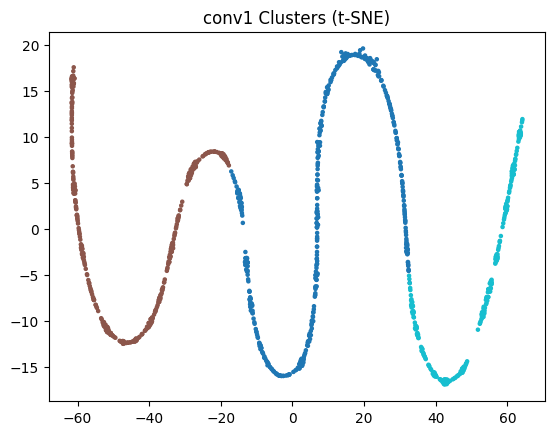

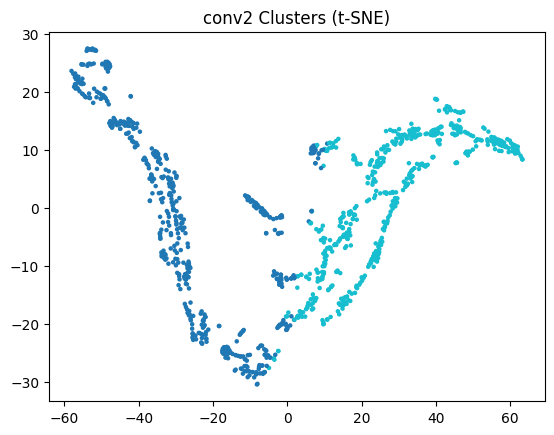

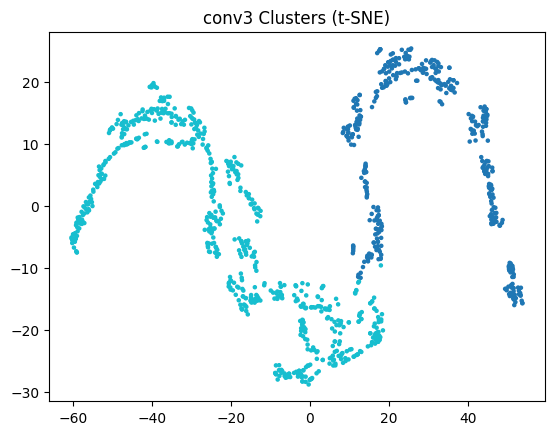

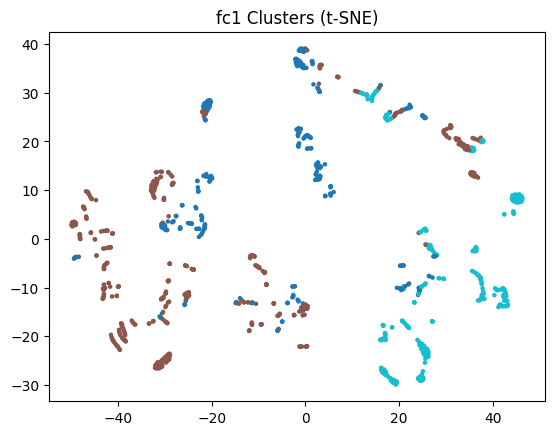

In [10]:
image_dir = "Data/Image/IQ-OTHNCCD"
dataloader, dataset = get_image_dataloader(
    image_dir=image_dir,
    batch_size=16,
    shuffle=True,
    metric_learning=False
)
num_classes = len(dataset.class_map)
model = SimpleCNN(num_classes=num_classes).to(device)

# 2) Train
train_network(model, dataloader, device, num_epochs=5, lr=1e-3, use_metric_learning=False)
torch.save(model.state_dict(), "lung_cancer_model.pth")

# 3) Extract activations
acts, labels = extract_activations(model, dataloader, device, metric_learning=False)
# 4) Clustering
clustering_res = perform_clustering_optimized(acts, max_clusters=10)
cluster_df = create_latent_cluster_dataset(clustering_res, labels)
print(cluster_df.head())

# 5) Causal Discovery
causal_graphs = causal_discovery_all_layers(cluster_df, layer_names=model.activations.keys())

# 6) Visualization
for layer in model.activations.keys():
    visualize_clusters(acts, clustering_res, layer)

Epoch [1/5], Loss: 1.0917
Epoch [2/5], Loss: 0.9173
Epoch [3/5], Loss: 0.9037
Epoch [4/5], Loss: 0.8933
Epoch [5/5], Loss: 0.8779
Training completed.
fc1: best_n=2, silhouette=0.4204
fc2: best_n=2, silhouette=0.3863
fc3: best_n=2, silhouette=0.4493
   fc1_cluster  fc2_cluster  fc3_cluster  label
0            0            0            0      0
1            1            0            1      0
2            0            0            0      0
3            0            0            0      0
4            0            0            0      1


Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 542.13it/s] 

Error in causal discovery: 'Edge' object is not subscriptable


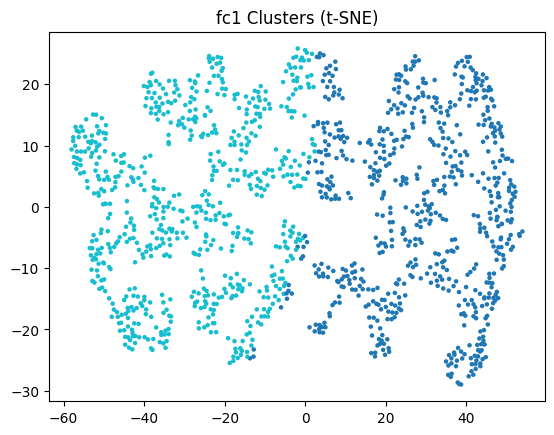

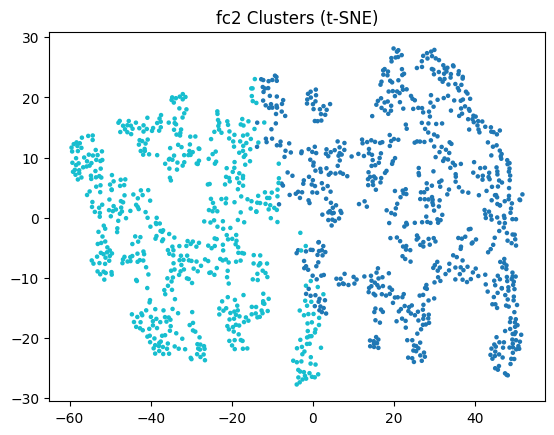

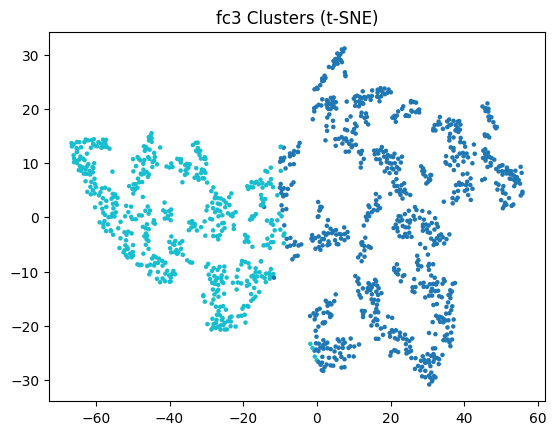

In [12]:
# TABULAR Example (Classification => 3 classes)
csv_path = "Data/Tabular/insurance.csv"
dl, ds = get_tabular_dataloader(csv_path, batch_size=32, shuffle=True, classification=True)

# number of classes = 3 (low, mid, high)
model = SimpleMLP(input_dim=6, hidden_dim=64, output_dim=3).to(device)

# 2) Train
train_network(model, dl, device, num_epochs=5, lr=1e-3, use_metric_learning=False)

# 3) Extract activations
#  (Now MLP has forward hooks, so same function!)
acts, labels = extract_activations(model, dl, device, metric_learning=False)

# 4) Clustering
clustering_res = perform_clustering_optimized(acts)
cluster_df = create_latent_cluster_dataset(clustering_res, labels)
print(cluster_df.head())

# 5) Causal
c_graphs = causal_discovery_all_layers(cluster_df, layer_names=model.activations.keys())

# 6) Visualize
for layer in model.activations.keys():
    visualize_clusters(acts, clustering_res, layer)
